In [50]:
import torch
import torchvision
from torchvision import transforms as tf
from torch import nn
import d2l.torch as d2l

## **Chapter 14. Computer Vision**

### **14.1 Image Augmentation**

Random tweaks of training examples allow models to rely less on certain specific attribute and so improving generalization ability.


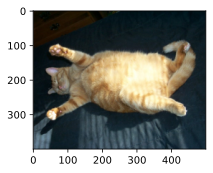

In [51]:
d2l.set_figsize()
img = d2l.Image.open("img/cat1.jpg")
d2l.plt.imshow(img);

In [52]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

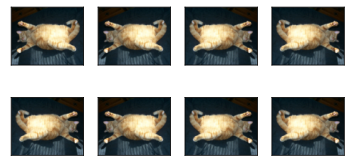

In [53]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

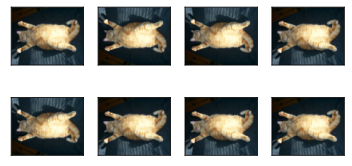

In [54]:
apply(img, torchvision.transforms.RandomVerticalFlip())

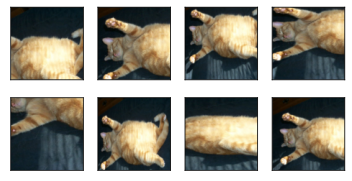

In [55]:
shape_aug = torchvision.transforms.RandomResizedCrop((200,200), scale=(0.1, 1), ratio=(0.5,2))
apply(img, shape_aug)

Next we change color by using `torchvision.transforms.ColorJitter` and specifying which of brightness, contrast, saturation or hue we want to randomly perturb and by what maximum possible amount.

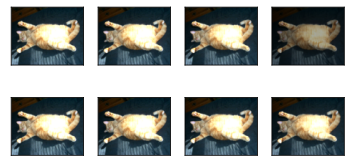

In [56]:
apply(img, torchvision.transforms.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0))

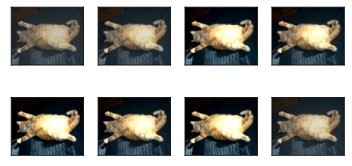

In [57]:
apply(img, torchvision.transforms.ColorJitter(brightness=0, contrast=0.5, saturation=0, hue=0))

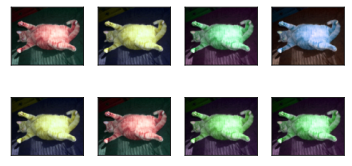

In [58]:
apply(img, torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.5))

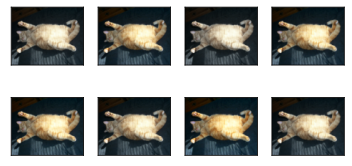

In [59]:
apply(img, torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0.5, hue=0))

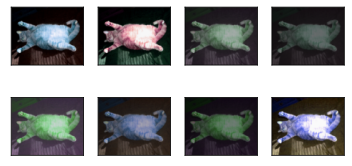

In [60]:
color_aug = torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

In practice we combine multiple augmentation methods using `torchvision.transforms.Compose`.

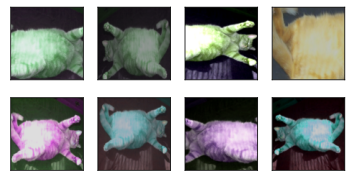

In [61]:
augs = torchvision.transforms.Compose([torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

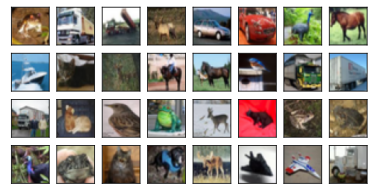

In [62]:
all_images = torchvision.datasets.CIFAR10(train=True, root="data", download=False)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

We only apply image augmentation to training examples.

In [63]:
train_augs = tf.Compose([tf.RandomHorizontalFlip(), tf.RandomResizedCrop(size=(32,32), scale=(0.8,1), ratio=(0.8,1.2)), tf.ToTensor()])
test_augs = tf.Compose([tf.ToTensor()])

In [64]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="data", train=is_train, transform=augs, download=False)
    
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    
    return dataloader

In [68]:
batch_size, devices, net = 256, [torch.device("mps")], d2l.resnet18(10, 3);

/Users/akshay/miniforge3/envs/d2l/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [69]:

def train_batch_ch13(net, X, y, loss, trainer, devices):
    """Train for a minibatch with multiple GPUs (defined in Chapter 13)."""
    if isinstance(X, list):
        # Required for BERT fine-tuning (to be covered later)
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum


def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    """Train a model with multiple GPUs (defined in Chapter 13)."""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples,
        # no. of predictions
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

In [67]:
net.apply(d2l.init_cnn);

In [71]:
def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    
    test_iter = load_cifar10(False, test_augs, batch_size)
    
    loss = nn.CrossEntropyLoss(reduction="none")
    
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    net(next(iter(train_iter))[0])
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

In [77]:
#train_with_data_aug(train_augs, #test_augs, net)


In [75]:
devices = [torch.device("mps")]

### **14.3 Object Detection and Bounding Boxes**



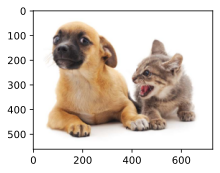

In [79]:
d2l.set_figsize()
img = d2l.plt.imread("img/catdog.jpeg")
d2l.plt.imshow(img);

The bounding box is rectangular, which is determined by the $x$ and $y$ coordinates of the upper-left corner of the rectangle and the such coordinates of the lower-right corner.

Another commonly used bounding box representation is the $(x,y)$-axis coordinates of the bounding box center, and the width and height of the box.

We will define functions to convert between two representations. The input argument boxes should be a two-dimensional tensor of shape $(n,4)$, where $n$ is the number of bounding boxes.

In [87]:
def box_corner_to_center(boxes):
    """Convert from (upper-left, lower-right) to (center, width, height)."""
    #         [x1, y1, x2, y2]
    #boxes = [33, 32, 55, 51], [11, 21, 45, 65], ...
    
    top_left = boxes[:, :2]
    lower_right = boxes[:, 2:]
    
    #(x1, y1) ... (x2, y1)
    #(x2, y1) ... (x2, y2)
    

    width = lower_right[:, 0] - top_left[:, 0]
    
    height = lower_right[:, 1] - top_left[:, 1]
    
    width_plus_height = torch.stack([width, height], dim=1)
    
    center = (top_left + lower_right) / 2
    
    return torch.concat([center, width_plus_height], dim=-1)
    
    
def box_center_to_corner(boxes):
    center = boxes[:, :2]
    w_h = boxes[:, 2:]
    
    top_left = center - w_h/2
    bottom_right = center + w_h/2
    return torch.concat([top_left, bottom_right], dim=-1)
    

In [88]:
# Here `bbox` is the abbreviation for bounding box
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]

In [89]:
boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

In [90]:
def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format.
    
    Given a bounding box in corner format return a rectangle in upper_left, width, height format"""
    return d2l.plt.Rectangle(
        xy = (bbox[0], bbox[1]),
        width = bbox[2] - bbox[0],
        height = bbox[3] - bbox[1],
        fill = False,
        edgecolor = color,
        linewidth = 2
    )

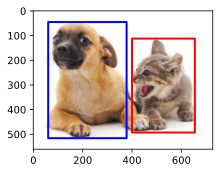

In [92]:
fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, "blue"))
fig.axes.add_patch(bbox_to_rect(cat_bbox, "red"));

### **14.4 Anchor Boxes**

We generate multiple bounding boxes with varying scales and aspect ratios centered on each pixel. These bounding boxes are called *anchor boxes*.

In [93]:
torch.set_printoptions(2)

We will generate anchor boxes with different shapes centered on each pixel of the image. Each anchor box will have *scale* $s \in (0,1]$ and the *aspect ratio* (ratio of width to height) $r > 0$. Then the width and height of the anchor box will be $ws \sqrt{r}$ and $\frac{hs}{\sqrt{r}}$.

We will consider a series of scales $s_1,\ldots, s_n$ and aspect ratios $r_1, \ldots, r_m$ and generate the boxes with either scale $s_1$ or aspect ratio $r_1$.

In [ ]:
def multibox_prior(data, sizes, ratios):
    """Generate anchor boxes with different shapes centered on each pixel.
    
    data: torch tensor of shape (N, C, h, w) corresponding to N images with C channels, each of shape (h,w)
    
    sizes: list of scales
    
    ratios: list of aspect ratios
    
    returns:
    a tensor of shape (N, num_boxes, 4)
    where num_boxes is (s + r - 1) * h * w and the 4 numbers corresponds to the corner representation of the box
    """
    
    